# NEW

In [2]:
from __future__ import print_function

import warnings
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU
from keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
import os

current_path = os.getcwd()
print(current_path)
warnings.filterwarnings("ignore")

d:\Project\VulScanner


In [3]:
df = pd.read_csv(current_path + '/Source2Slice/processed_gadgets_3.csv')

In [4]:
df.head()

,gadget,label
0,const app = express();\napp.get('/file/:filePa...,1
1,"\napp.get('/read/:filePath', (req, res) => {\n...",0
2,"\napp.get('/config', (req, res) => {\n cons...",1
3,"\napp.get('/config', (req, res) => {\n cons...",1
4,"\napp.get('/config', (req, res) => {\n cons...",1


In [5]:
# Cleaning data 
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
#df.columns = ['code', 'label']
# rename the columns to code and label
df.columns = ['code', 'label']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   code    48 non-null     object
 1   label   48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 900.0+ bytes


In [6]:
df.head()

,code,label
0,const app = express();\napp.get('/file/:filePa...,1
1,"\napp.get('/read/:filePath', (req, res) => {\n...",0
2,"\napp.get('/config', (req, res) => {\n cons...",1
3,const fs = require('fs');\nconst path = requir...,0
4,"\napp.get('/', (req, res) => {\n const userIn...",0


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModel
import torch

class BLSTM:
    def __init__(self, data, name="", batch_size=64, epochs=20, max_length=128):
        self.data = data
        self.name = name
        self.batch_size = batch_size
        self.epochs = epochs
        self.max_length = max_length

        # Load CodeBERT tokenizer and embedding model
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        self.embedding_model = AutoModel.from_pretrained("microsoft/codebert-base")

        # Preprocess data
        self._preprocess_data()

        # Build and compile model
        self.model = self._build_model()

    def _preprocess_data(self):
        self.data['label'] = self.data['label'].astype(int)
        
        embeddings = []
        for code in self.data['code']:
            inputs = self.tokenizer(code, return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings.append(embedding)

        self.X = np.array(embeddings).squeeze()
        self.y = self.data['label'].values

        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=12
        )

    def _build_model(self):
        model = Sequential()
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(self.X_train.shape[1], 1)))
        model.add(Dropout(0.5))
        model.add(BatchNormalization())
        model.add(Bidirectional(LSTM(64)))
        model.add(Dropout(0.5))
        model.add(Dense(128, activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(0.3))
        model.add(Dense(1, activation='sigmoid'))
    
        model.compile(optimizer=Adam(learning_rate=0.02), loss='binary_crossentropy', metrics=['accuracy', 'AUC'])
    
        return model

    def train(self):
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        model_checkpoint = ModelCheckpoint(self.name + "_best_model.weights.keras", save_best_only=True, monitor='val_loss')
        
        history = self.model.fit(
            self.X_train, self.y_train,
            validation_data=(self.X_test, self.y_test),
            batch_size=self.batch_size,
            epochs=self.epochs,
            callbacks=[early_stopping, model_checkpoint]
        )

        self._plot_learning_curve(history)

    def _plot_learning_curve(self, history):
        plt.figure(figsize=(10, 6))
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.ylim(0, 1)  # Set y-axis limit for accuracy
        plt.title('Model Accuracy')
        plt.ylabel('Accuracy')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

        plt.figure(figsize=(10, 6))
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.ylim(0, 2)  # Set y-axis limit for loss
        plt.title('Model Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(loc='upper left')
        plt.show()

    def test(self):
        self.model.load_weights(self.name + "_best_model.weights.keras")
        results = self.model.evaluate(self.X_test, self.y_test)
        print("Test loss:", results[0])
        print("Test accuracy:", results[1])
        print("Test AUC:", results[2])

    def predict_code(self, file_path):
        with open(file_path, 'r') as f:
            code_lines = f.readlines()

        vulnerable_lines = []
        predictions = []

        for idx, line in enumerate(code_lines):
            line = line.strip()
            if not line:
                continue
            inputs = self.tokenizer([line], return_tensors="pt", padding="max_length", truncation=True, max_length=self.max_length)
            with torch.no_grad():
                outputs = self.embedding_model(**inputs)
            embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings = np.expand_dims(embeddings, axis=1)

            prediction = self.model.predict(embeddings)
            predicted_class = 1 if prediction > 0.5 else 0

            predictions.append(predicted_class)
            if predicted_class == 1:
                vulnerable_lines.append(idx)

        result = "Vulnerable" if 1 in predictions else "Non-Vulnerable"
        vulnerable_code_lines = [f"{idx + 1}: {code_lines[i].strip()}" for i in vulnerable_lines]

        return result, vulnerable_code_lines


Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 917ms/step - AUC: 0.5525 - accuracy: 0.5167 - loss: 0.9222 - val_AUC: 0.8800 - val_accuracy: 0.5000 - val_loss: 0.6728
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - AUC: 0.6296 - accuracy: 0.6111 - loss: 0.9130 - val_AUC: 0.9400 - val_accuracy: 0.5000 - val_loss: 0.9112
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 521ms/step - AUC: 0.5073 - accuracy: 0.5739 - loss: 1.0930 - val_AUC: 0.8000 - val_accuracy: 0.5000 - val_loss: 0.8001
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 507ms/step - AUC: 0.6327 - accuracy: 0.5605 - loss: 0.8435 - val_AUC: 0.9200 - val_accuracy: 0.5000 - val_loss: 0.8427
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 528ms/step - AUC: 0.4306 - accuracy: 0.3951 - loss: 1.0448 - val_AUC: 0.7200 - val_accuracy: 0.5000 - val_loss: 0.7645
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 515ms/step - AUC: 0.6341 - accuracy: 0.5616 - loss: 0.7326 - val_AUC: 0.2000 - val_accuracy: 0.5000 - val_loss: 0.7167


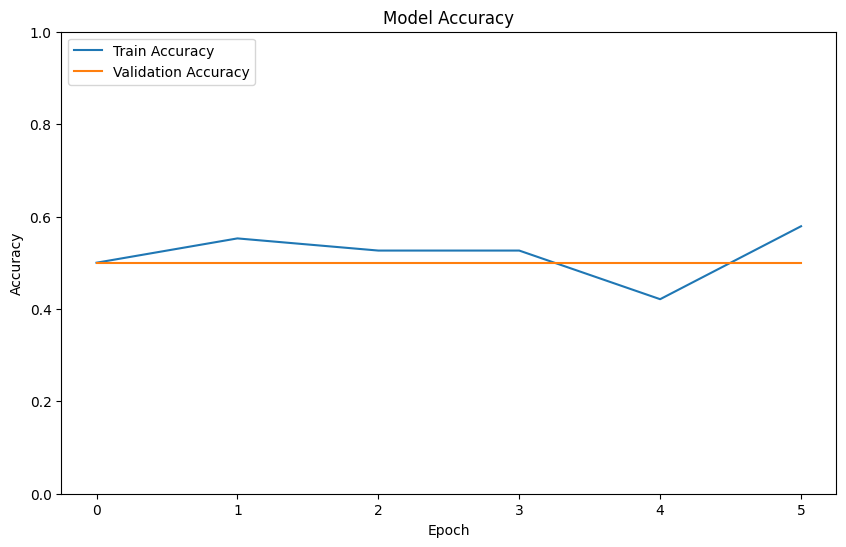

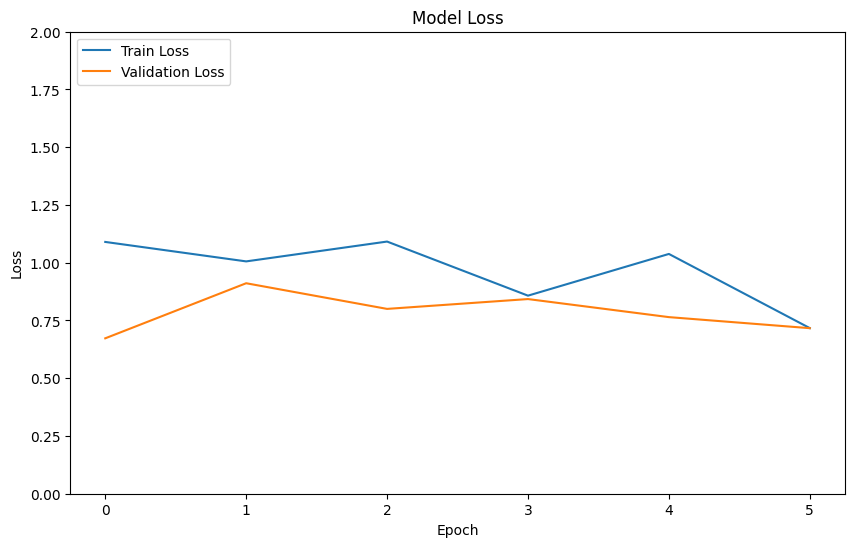

In [8]:
blstm = BLSTM(df, name="codebert_blstm_model", batch_size=10, epochs=100)
blstm.train()

In [9]:
blstm.test()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - AUC: 0.8800 - accuracy: 0.5000 - loss: 0.6728   
Test loss: 0.6727598905563354
Test accuracy: 0.5
Test AUC: 0.8799999952316284


In [15]:
class SimpleCodeClassifier:
    def __init__(self, data, model_type="logistic"):
        self.data = data
        self.model_type = model_type

        # Load CodeBERT tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained("microsoft/codebert-base")
        self.embedding_model = AutoModel.from_pretrained("microsoft/codebert-base")

        # Preprocess data and extract embeddings
        self._preprocess_data()

        # Choose classifier
        self.model = self._choose_classifier()

    def _preprocess_data(self):
        # Tokenize code snippets and get embeddings
        embeddings = []
        for code in self.data['code']:
            inputs = self.tokenizer(code, return_tensors="pt", padding=True, truncation=True)
            outputs = self.embedding_model(**inputs)
            embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy()
            embeddings.append(embedding)

        self.X = np.array(embeddings).squeeze()
        self.y = self.data['label'].values

        # Split dataset
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

    def _choose_classifier(self):
        if self.model_type == "logistic":
            return LogisticRegression()
        elif self.model_type == "svm":
            return SVC(probability=True)
        elif self.model_type == "random_forest":
            return RandomForestClassifier()

    def train(self):
        self.model.fit(self.X_train, self.y_train)

    def test(self):
        y_pred = self.model.predict(self.X_test)
        y_pred_proba = self.model.predict_proba(self.X_test)[:, 1]

        accuracy = accuracy_score(self.y_test, y_pred)
        auc = roc_auc_score(self.y_test, y_pred_proba)

        print(f"Test accuracy: {accuracy}")
        print(f"Test AUC: {auc}")

    def predict_code(self, file_path):
        # Read the entire source code from the file
        with open(file_path, 'r') as f:
            code = f.read().strip()
    
        # Tokenize and embed the entire code
        inputs = self.tokenizer(code, return_tensors="pt", padding=True, truncation=True)
        outputs = self.embedding_model(**inputs)
    
        # Take mean of the embeddings along the sequence length to get a single 2D vector
        embedding = outputs.last_hidden_state.mean(dim=1).detach().numpy().squeeze()
    
        # Predict the label (vulnerable or non-vulnerable) for the entire file
        prediction = self.model.predict(np.array([embedding]))[0]  # Predict expects a 2D array
    
        # Interpret the prediction result
        result = "Vulnerable" if prediction == 1 else "Non-Vulnerable"
    
        return result


In [18]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

simple_classifier = SimpleCodeClassifier(df, model_type="logistic")
simple_classifier.train()

In [20]:
simple_classifier.test()

Test accuracy: 0.8
Test AUC: 0.8571428571428572


# Predict With BLSTM

In [10]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/nonvuln.js')

print(f"The predicted label for the source code is: {prediction}")

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 768 and 1 for '{{node sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/bidirectional_1/forward_lstm_1/strided_slice_1, sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,768], [1,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 768), dtype=float32)
  • states=('tf.Tensor(shape=(1, 128), dtype=float32)', 'tf.Tensor(shape=(1, 128), dtype=float32)')
  • training=False

In [243]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/nonvuln2.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
The predicted label for the source code is: ('Vulnerable', ['15: // Function to calculate the factorial of a number', '15: function factorial(n) {', '15: if (n < 0) {', '15: return "Factorial is not defined for negative numbers";', '15: } else if (n === 0 || n === 1) {', '15: return 1; // Base case', '15: } else {', '15: return n * factorial(n - 1); // Recursive case', '15: }', '15: }', '15: // Example usage', '15: const number = 5;', '15: const result = factorial

In [11]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/vuln2.js')

print(f"The predicted label for the source code is: {prediction}")

ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 768 and 1 for '{{node sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/bidirectional_1/forward_lstm_1/strided_slice_1, sequential_1/bidirectional_1/forward_lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [1,768], [1,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(1, 768), dtype=float32)
  • states=('tf.Tensor(shape=(1, 128), dtype=float32)', 'tf.Tensor(shape=(1, 128), dtype=float32)')
  • training=False

In [245]:
# Predicting vulnerability for the whole file
prediction = blstm.predict_code(current_path + '/SourceCode/vuln2.js')

print(f"The predicted label for the source code is: {prediction}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted label for the source code is: ('Vulnerable', ["21: const express = require('express');", "21: const fs = require('fs');", "21: const path = require('path');", '21: const app = express();', '21: const port = 3000;', "21: app.get('/file', (req, res) => {", '21: const fileName = req.query.file;', '21: co

In [233]:
prediction, vulnerable_lines = blstm.predict_code(current_path + '/SourceCode/nonvuln.js')

print(f"The predicted label for the source code is: {prediction}")
print(f"Vulnerable lines found:")
for line in vulnerable_lines:
    print(line)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
The predicted label for the source code is: Vulnerable
Vulnerable lines found:
13: const fs = require('fs');
13: const path = require('path');
13: const filePath = path.join(__dirname, 'file.txt');
13: async function readFile() {
13: try {
13: await fs.promises.access(filePath, fs.constants.F_OK);
13: const data = await fs.promises.readFile(filePath, 'utf8');
13: console.log(data);
13: } catch (err) {
13: console.error('Error reading the file:', err.message);
13: }
13: }
13: readFile();


# Predict with Simple

In [24]:
file_path = current_path + '/SourceCode/nonvuln.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Non-Vulnerable


In [23]:
file_path = current_path + '/SourceCode/vuln.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Non-Vulnerable


In [21]:
file_path = current_path + '/SourceCode/vuln2.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Non-Vulnerable


In [25]:
file_path = current_path + '/SourceCode/nonvuln2.js'  # Replace with your file path
result = simple_classifier.predict_code(file_path)

# Print the prediction result
print("Prediction for the file:", result)

Prediction for the file: Non-Vulnerable


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5982bd9-4186-4df6-a44f-a0eeec8cd72d' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>